In [3]:
from __future__ import print_function, division, absolute_import

import GPy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import safeopt

mpl.rcParams['figure.figsize'] = (12.0, 6.0)
mpl.rcParams['font.size'] = 12
mpl.rcParams['lines.markersize'] = 12

## Define a kernel and function

Here we define a kernel. The function is drawn at random from the GP and is corrupted my Gaussian noise

In [4]:
# Measurement noise
noise_var = 0.05 ** 2

# Bounds on the inputs variable
bounds = [(-10., 10.)]
parameter_set = safeopt.linearly_spaced_combinations(bounds, 1000)

# Define Kernel
kernel = GPy.kern.RBF(input_dim=len(bounds), variance=2., lengthscale=1.0, ARD=True)

# Initial safe point
x0 = np.zeros((1, len(bounds)))

# Generate function with safe initial point at x=0
def sample_safe_fun():
    while True:
        fun = safeopt.sample_gp_function(kernel, bounds, noise_var, 100)
        if fun(0, noise=False) > 0.5:
            break
    return fun

## Interactive run of the algorithm

In [5]:
# Define the objective function
fun = sample_safe_fun()

# The statistical model of our objective function
gp = GPy.models.GPRegression(x0, fun(x0), kernel, noise_var=noise_var)

# The optimization routine
# opt = safeopt.SafeOptSwarm(gp, 0., bounds=bounds, threshold=0.2)
# opt = safeopt.SafeOpt(gp, parameter_set, 0., lipschitz=None, threshold=0.2)
opt = safeopt.LinearEntropySearch(gp, 0., bounds)

(100,)


AssertionError: need at least column vectors as inputs to kernels for now, given X2.shape=(1, 1, 100)

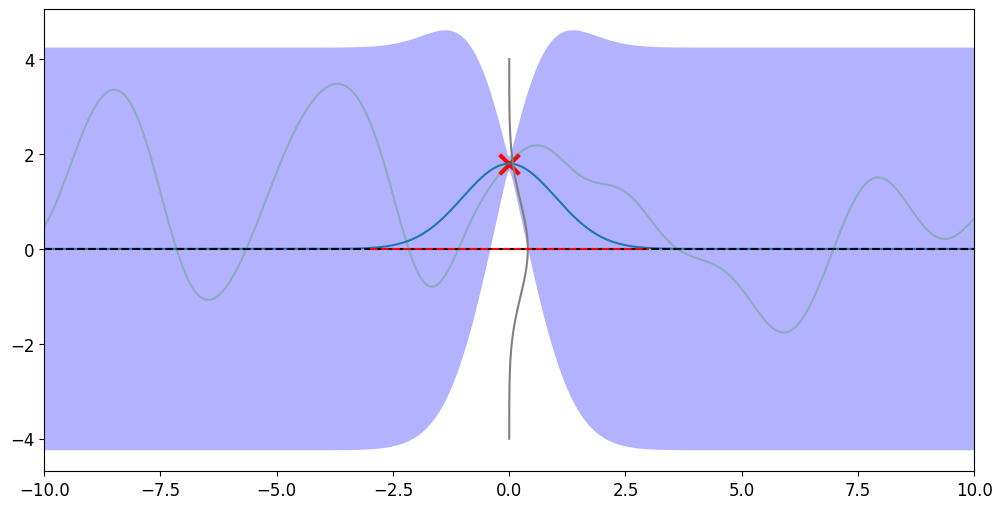

In [6]:
def plot_gp():
    # Plot the GP
    opt.plot(1000)
    # Plot the true function
    plt.plot(parameter_set, fun(parameter_set, noise=False), color='C2', alpha=0.3)
    opt.verify_ymax_estimate()
plot_gp()

In [ ]:
# Obtain next query point
x_next = opt.optimize(np.linspace(-3,3,100))
# Get a measurement from the real system
y_meas = fun(x_next)
# Add this to the GP model

opt.add_new_data_point(x_next, y_meas)
opt.verify_ymax_estimate()
plot_gp()
plt.plot(np.linspace(-3,3,100), 5 * np.array(opt.deltasigs).squeeze())
plt.plot((opt.grid.squeeze(), opt.grid.squeeze()), (-2,2))